# Transformer

Best pearson: mlp_embed_dim        100
num_encoder_units      1
pdropout             0.2
Name: 17, dtype: object
Best spearman: mlp_embed_dim        100
num_encoder_units      1
pdropout             0.2
Name: 17, dtype: object


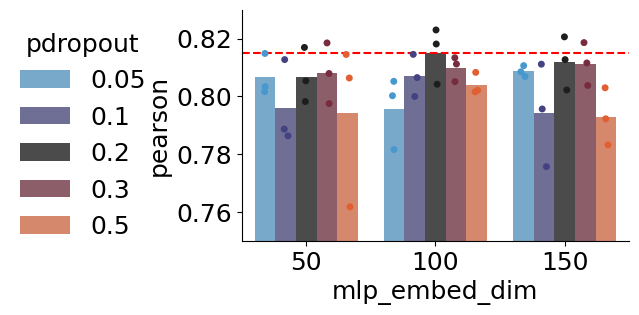

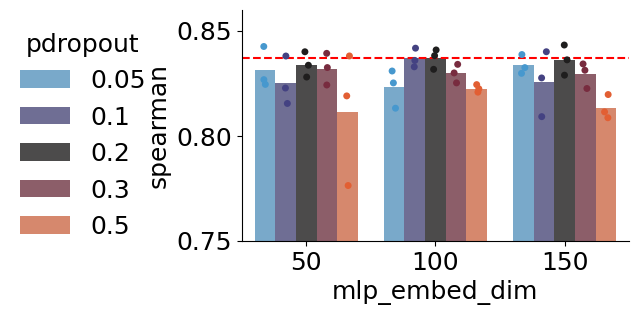

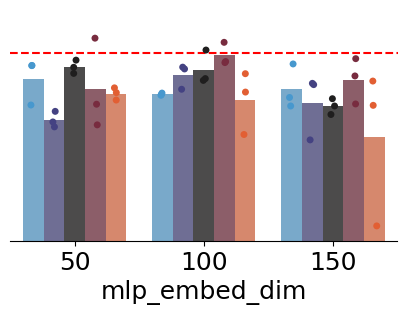

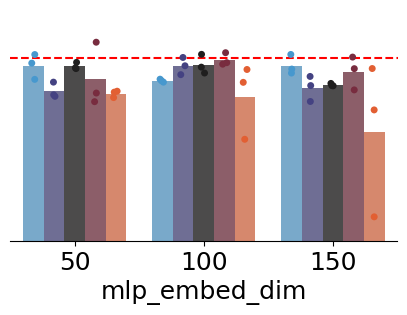

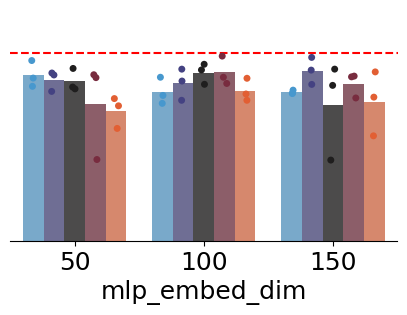

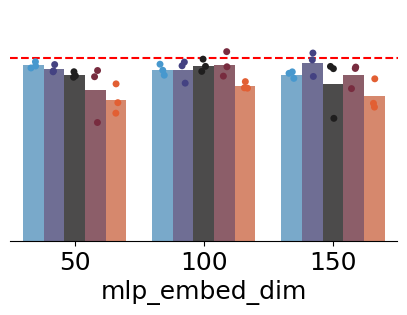

In [9]:
# Analyse the performance of transformer tuning
import pandas as pd
from os.path import join as pjoin
from ast import literal_eval
import numpy as np

# collect pandas warnings
import warnings
warnings.filterwarnings("ignore")

data = pjoin('models', 'data', 'performance', 'transformer-train-fine-tune.csv')

df = pd.read_csv(data)
# remove the rows with nan values


# remove module__ prefix from the column names
df.columns = df.columns.str.replace('module__', '')

parameters = ['module__mlp_embed_dim', 'module__num_encoder_units', 'module__pdropout']
parameters = [p.replace('module__', '') for p in parameters]
pearson = 'pearson'
spearman = 'spearman'

# for each of these parameters, fix the other two and plot the performances
# for the third one, the x axis shows the values of the other two parameters
# for the y axis, show the performance, current parameter is shown using hue
import seaborn as sns
import matplotlib.pyplot as plt

df_pearson_mean = df.copy()
df_spearman_mean = df.copy()
df_pearson_mean[pearson] = df_pearson_mean[pearson].apply(literal_eval)
df_spearman_mean[spearman] = df_spearman_mean[spearman].apply(literal_eval)
df_pearson_mean[pearson] = df_pearson_mean[pearson].apply(lambda x: np.mean(x))
df_spearman_mean[spearman] = df_spearman_mean[spearman].apply(lambda x: np.mean(x))
# find the best performing parameter values
best_pearson = df_pearson_mean[pearson].idxmax()
best_spearman = df_spearman_mean[spearman].idxmax()
best_pearson_values = df.iloc[best_pearson][parameters]
best_spearman_values = df.iloc[best_spearman][parameters]
print(f'Best pearson: {best_pearson_values}')
print(f'Best spearman: {best_spearman_values}')


parameter = 'pdropout'
other_parameter = 'num_encoder_units'
last_parameter = 'mlp_embed_dim'
palette = sns.color_palette("icefire", len(df[parameter].unique()))

other_parameter_values = df[other_parameter].unique()
first = True
highest_pearson = 0
highest_spearman = 0
for other_parameter_value in other_parameter_values:
    if not first:
        fig_pearson, ax_pearson = plt.subplots(figsize=(5, 3))
    else:
        fig_pearson, ax_pearson = plt.subplots(figsize=(5, 3))
    df_filtered = df[df[other_parameter] == other_parameter_value]
    # the performance values are lists recorded as strings, convert them to lists
    df_filtered[pearson] = df_filtered[pearson].apply(literal_eval)
    df_strip = df_filtered.copy()
    df_strip = df_strip.explode(pearson)
    df_filtered[pearson] = df_filtered[pearson].apply(lambda x: np.mean(x))
    # draw the histogram
    sns.barplot(x=last_parameter, y=pearson, hue=parameter, data=df_filtered,  dodge=True, alpha=0.8, ax=ax_pearson, palette=palette) 
    sns.stripplot(x=last_parameter, y=pearson, hue=parameter, data=df_strip, dodge=True, alpha=1, ax=ax_pearson, palette=palette, jitter=0.1, legend=False)
    ax_pearson.set_ylim(.75, .83)


    # do the same for spearman
    if not first:
        fig_spearman, ax_spearman = plt.subplots(figsize=(5, 3))
    else:
        fig_spearman, ax_spearman = plt.subplots(figsize=(5, 3))
    df_filtered[spearman] = df_filtered[spearman].apply(literal_eval)
    df_strip = df_filtered.copy()
    df_strip = df_strip.explode(spearman)
    df_filtered[spearman] = df_filtered[spearman].apply(lambda x: np.mean(x))
    sns.barplot(x=last_parameter, y=spearman, hue=parameter, data=df_filtered,  dodge=True, alpha=0.8, ax=ax_spearman, palette=palette)
    sns.stripplot(x=last_parameter, y=spearman, hue=parameter, data=df_strip, dodge=True, alpha=1, ax=ax_spearman, palette=palette, jitter=0.1, legend=False)
    ax_spearman.set_ylim(.75, .86)    

    # remove the top and right spines
    ax_pearson.spines['top'].set_visible(False)
    ax_pearson.spines['right'].set_visible(False)
    ax_spearman.spines['top'].set_visible(False)
    ax_spearman.spines['right'].set_visible(False)
    
    # increase the font size
    font_size = 18
    plt.rcParams['legend.title_fontsize'] = font_size
    ax_pearson.set_xlabel(last_parameter, fontsize=font_size)
    ax_pearson.set_ylabel(pearson, fontsize=font_size)
    ax_spearman.set_xlabel(last_parameter, fontsize=font_size)
    ax_spearman.set_ylabel(spearman, fontsize=font_size)
    ax_pearson.tick_params(axis='both', which='major', labelsize=font_size)
    ax_spearman.tick_params(axis='both', which='major', labelsize=font_size)
    ax_pearson.legend(loc='upper left', title=parameter, bbox_to_anchor=(-0.63, 1), fontsize=font_size, frameon=False)
    ax_spearman.legend(loc='upper left', title=parameter, bbox_to_anchor=(-0.63, 1), fontsize=font_size, frameon=False)
    
    # if not first, remove the y axis
    if not first:
        ax_pearson.set_ylabel('')
        ax_spearman.set_ylabel('')
        ax_pearson.set_yticks([])
        ax_spearman.set_yticks([])
        ax_pearson.spines['left'].set_visible(False)
        ax_spearman.spines['left'].set_visible(False)   
        # remove legend
        ax_pearson.get_legend().remove()
        ax_spearman.get_legend().remove()
    else:
        first = False
        highest_pearson = df_filtered[pearson].max()
        highest_spearman = df_filtered[spearman].max()
        
    # draw the horizontal line for the best performing parameter
    ax_pearson.axhline(highest_pearson, color='r', linestyle='--')
    ax_spearman.axhline(highest_spearman, color='r', linestyle='--')
    
    figure_name = f'{parameter}-{other_parameter}-fixed-at-{other_parameter_value}'
    fig_pearson.savefig(pjoin('dissertation', 'figures', f'transformer-tune-{figure_name}-pearson.png'), bbox_inches='tight', dpi=300)
    fig_spearman.savefig(pjoin('dissertation', 'figures', f'transformer-tune-{figure_name}-spearman.png'), bbox_inches='tight', dpi=300)

In [26]:
# Analyse the performance of transformer tuning
import pandas as pd
from os.path import join as pjoin
from ast import literal_eval
import numpy as np

data = pjoin('models', 'data', 'performance', 'transformer-train-fine-tune.csv')

df = pd.read_csv(data)
# remove the rows with nan values
df = df.dropna()
print(df)

    module__mlp_embed_dim  module__num_encoder_units  module__pdropout  \
0                      50                          1              0.05   
1                      50                          1              0.10   
2                      50                          1              0.20   
3                      50                          1              0.50   
4                      50                          3              0.05   
5                      50                          3              0.10   
6                      50                          3              0.20   
8                      50                          5              0.05   
9                      50                          5              0.10   
10                     50                          5              0.20   
12                    100                          1              0.05   
13                    100                          1              0.10   
14                    100             

# AdaBoost tuning

Best pearson: power          3
threshold    0.7
rounds         1
Name: 53, dtype: object
Best spearman: power          3
threshold    0.5
rounds         1
Name: 52, dtype: object


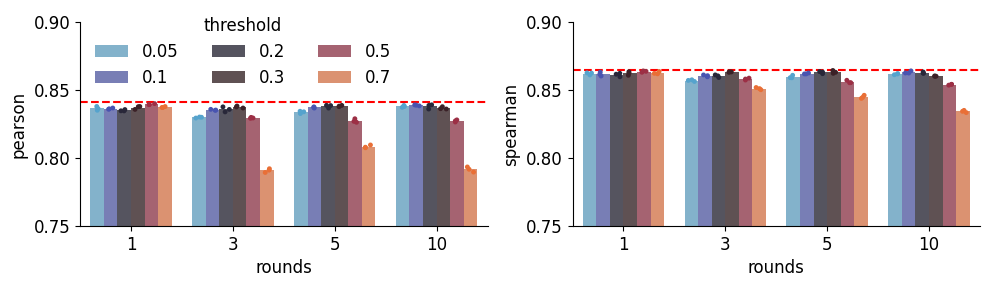

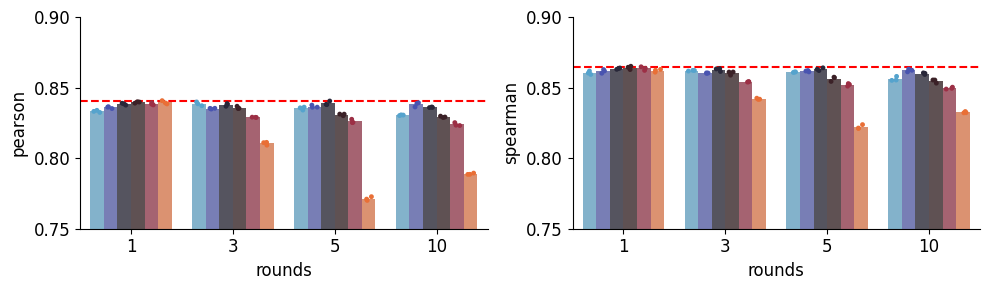

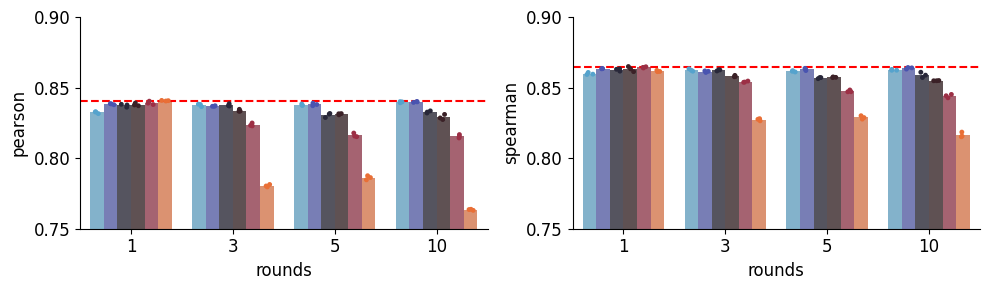

In [13]:
# Analyse the performance of transformer tuning
import pandas as pd
from os.path import join as pjoin
from ast import literal_eval
import numpy as np

# collect pandas warnings
import warnings
warnings.filterwarnings("ignore")

data = pjoin('models', 'data', 'performance', 'ensemble_adaboost_params.csv')

df = pd.read_csv(data)
# remove the rows with nan values


# remove module__ prefix from the column names
df.columns = df.columns.str.replace('module__', '')

parameters = ['power', 'threshold', 'rounds']
parameters = [p.replace('module__', '') for p in parameters]
pearson = 'pearson'
spearman = 'spearman'

# for each of these parameters, fix the other two and plot the performances
# for the third one, the x axis shows the values of the other two parameters
# for the y axis, show the performance, current parameter is shown using hue
import seaborn as sns
import matplotlib.pyplot as plt

df_pearson_mean = df.copy()
df_spearman_mean = df.copy()
df_pearson_mean[pearson] = df_pearson_mean[pearson].apply(literal_eval)
df_spearman_mean[spearman] = df_spearman_mean[spearman].apply(literal_eval)
df_pearson_mean[pearson] = df_pearson_mean[pearson].apply(lambda x: np.mean(x))
df_spearman_mean[spearman] = df_spearman_mean[spearman].apply(lambda x: np.mean(x))
# find the best performing parameter values
best_pearson = df_pearson_mean[pearson].idxmax()
best_spearman = df_spearman_mean[spearman].idxmax()
best_pearson_values = df.iloc[best_pearson][parameters]
best_spearman_values = df.iloc[best_spearman][parameters]
print(f'Best pearson: {best_pearson_values}')
print(f'Best spearman: {best_spearman_values}')

highest_pearson = df_pearson_mean[pearson].max()
highest_spearman = df_spearman_mean[spearman].max()


parameter = 'threshold'
other_parameter = 'power'
last_parameter = 'rounds'
palette = sns.color_palette("icefire", len(df[parameter].unique()))
first = True

other_parameter_values = df[other_parameter].unique()
for other_parameter_value in other_parameter_values:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    ax_pearson, ax_spearman = axes  
    
    df_filtered = df[df[other_parameter] == other_parameter_value]
    # the performance values are lists recorded as strings, convert them to lists
    df_filtered[pearson] = df_filtered[pearson].apply(literal_eval)
    df_strip = df_filtered.copy()
    df_pearson_means = df_pearson_mean[pearson]
    df_strip[pearson] = df_strip[pearson].apply(lambda x: x + np.random.normal(-0.001, 0.001, len(x)))
    df_strip[pearson] = df_strip[pearson] - (df_strip[pearson].apply(lambda x: np.mean(x)) - df_pearson_means)
    df_strip = df_strip.explode(pearson)
    df_filtered[pearson] = df_filtered[pearson].apply(lambda x: np.mean(x))
    # draw the histogram
    sns.barplot(x=last_parameter, y=pearson, hue=parameter, data=df_filtered,  dodge=True, alpha=0.8, ax=ax_pearson, palette=palette) 
    sns.stripplot(x=last_parameter, y=pearson, hue=parameter, data=df_strip, dodge=True, alpha=1, ax=ax_pearson, palette=palette, jitter=0.2, legend=False, size=3.5)
    ax_pearson.set_ylim(.75, .9)


    df_filtered[spearman] = df_filtered[spearman].apply(literal_eval)
    df_strip = df_filtered.copy()
    df_spearman_means = df_spearman_mean[spearman]
    df_strip[spearman] = df_strip[spearman].apply(lambda x: x + np.random.normal(-0.001, 0.001, len(x)))
    df_strip[spearman] = df_strip[spearman] - (df_strip[spearman].apply(lambda x: np.mean(x)) - df_spearman_means)
    df_strip = df_strip.explode(spearman)
    df_filtered[spearman] = df_filtered[spearman].apply(lambda x: np.mean(x))
    sns.barplot(x=last_parameter, y=spearman, hue=parameter, data=df_filtered,  dodge=True, alpha=0.8, ax=ax_spearman, palette=palette, legend=False)
    sns.stripplot(x=last_parameter, y=spearman, hue=parameter, data=df_strip, dodge=True, alpha=1, ax=ax_spearman, palette=palette, jitter=0.2, legend=False, size=3.5)
    ax_spearman.set_ylim(.75, .9)    

    # remove the top and right spines
    ax_pearson.spines['top'].set_visible(False)
    ax_pearson.spines['right'].set_visible(False)
    ax_spearman.spines['top'].set_visible(False)
    ax_spearman.spines['right'].set_visible(False)
    
    # increase the font size
    font_size = 12
    plt.rcParams['legend.title_fontsize'] = font_size
    ax_pearson.set_xlabel(last_parameter, fontsize=font_size)
    ax_pearson.set_ylabel(pearson, fontsize=font_size)
    ax_spearman.set_xlabel(last_parameter, fontsize=font_size)
    ax_spearman.set_ylabel(spearman, fontsize=font_size)
    ax_pearson.tick_params(axis='both', which='major', labelsize=font_size)
    ax_spearman.tick_params(axis='both', which='major', labelsize=font_size)
    if first:
        ax_pearson.legend(loc='upper left', fontsize=font_size, frameon=False, ncol=3, title=parameter, bbox_to_anchor=(0, 1.1))
        first = False
    else:
        # remove the legend
        ax_pearson.get_legend().remove()
        
    # draw the horizontal line for the best performing parameter
    ax_pearson.axhline(highest_pearson, color='r', linestyle='--')
    ax_spearman.axhline(highest_spearman, color='r', linestyle='--')
    
    plt.tight_layout()
    
    # save the figure
    figure_name = f'{parameter}-{other_parameter}-fixed-at-{other_parameter_value}'
    fig.savefig(pjoin('dissertation', 'figures', f'ensemble-adaboost-{figure_name}.png'), bbox_inches='tight', dpi=300)